In [1]:
import numpy as np
import pandas as pd
#import plotly.express as px
#from plotly.subplots import make_subplots
#import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#import mplcyberpunk
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
sns.set(style="white", palette="muted", color_codes=True)
pd.set_option("display.width", 1000)


In [2]:
bs_df = pd.read_csv("C:/Users/emirh/Downloads/full_data.csv")

In [3]:
path="C:/Users/emirh/Downloads/full_data.csv"

In [4]:
bs_df.columns = bs_df.columns.str.lower()
discrete_cols = [var for var in bs_df.columns if bs_df[var].dtypes!="O" and bs_df[var].nunique()<10]
continuous_cols = [var for var in bs_df.columns if bs_df[var].dtypes!="O" and var!="stroke" and var not in discrete_cols ]
cat_cols = [var for var in bs_df.columns if bs_df[var].dtypes=="O"]
#numerical_cols = [var for var in bs_df.columns if bs_df[var].dtypes != "O" and var != "stroke"]
mixed_cols = discrete_cols + cat_cols
    

In [7]:
class DataOperation:
    
    def __init__(self,df):
        self.df=df
        
    def data_preview(self):

        print(self.df.head())
        print("*"*40)
        print(f"Shape of data: {self.df.shape}")
        print("*"*40)
        print(self.df.info())
        print("*"*40)
        print(self.df.describe().T)

    def data_summary(self):
        global discrete_cols,continuous_cols,cat_cols,mixed_cols
        
        cardinality = self.df[cat_cols].nunique()

        print(f"Total Discrete Variables: {len(discrete_cols)} --> {discrete_cols}")
        print(f"Total Continuous Variables: {len(continuous_cols)} --> {continuous_cols}")
        print(f"Total Categorical Variables: {len(cat_cols)} --> {cat_cols}")
        print("*"*40)
        print(f"Cardinality: \n{cardinality}")
        for col in self.df[mixed_cols]:
            print("*"*40)
            print(f"Counts of unique values for variables:\n\033[1m {col} \033[0m \n{self.df[col].value_counts()}")

    def missing_values_analysis(self):
        
        if self.df.isnull().sum().any():
            missing_percent = self.df.isnull().sum()/len(self.df)*100
            missing_total = self.df.isnull().sum()
            missing_table = pd.concat([missing_total,missing_percent],axis=1)
            missing_table.rename(columns={0:"Missing Value",1:"% of Total Value"},inplace=True)
            missing_table.sort_values(by="% of Total Value",ascending=False).round(1)
        else:
            print("There is no missing value.")

    def numerical_viz(self):
        global continuous_cols

        for col in self.df[continuous_cols]:
            
            fig, ax = plt.subplots(1, 2, sharex=True,figsize=(10, 4))
            sns.set_color_codes(palette="pastel")
            sns.histplot(x=self.df[col],ax=ax[0],kde=True).set(title=f"Distribution of {col}")
            sns.boxplot(x=self.df[col],ax=ax[1]).set(title=f"Box-plot of {col}")
            sns.despine(left=True)
            plt.show() 
              
    def categorical_viz(self):
        global mixed_cols
        c=1
        fig = plt.figure(figsize=(15,10))
        for col in self.df[mixed_cols]:

            plt.subplot(2,4,c)
            sns.countplot(x=self.df[col]).set(title=f"Plot of {col}")
            plt.xticks(rotation=30)
            sns.despine()
            c = c+1
        plt.tight_layout()    
        plt.show()

    def skewness_kurtosis(self):
        global continuous_cols
        skew={}
        kurt={}
        for col in self.df[continuous_cols]:
            skewness = self.df[col].skew(axis=0).round(2)
            kurtosis = self.df[col].kurtosis(axis=0).round(2)
            skew[col]=skewness
            kurt[col]=kurtosis
        skw_kurt=pd.DataFrame({"skew":skew,"kurtosis":kurt}).T
        print(skw_kurt) 
        for col in skw_kurt.columns:
            if ((skw_kurt[col].iloc[0] > 1.5) | (skw_kurt[col].iloc[0] < -1.5)) and ((skw_kurt[col].iloc[1] > 1.5) | (skw_kurt[col].iloc[1] <-1.5)):
                print("*"*30)
                print(f"\033[1mSkewness and kurtosis were detected.\033[0m\nVariable: {col}\n\033[1mWe'll apply Box-Cox transformation.\033[0m")
                self.df[col +"_boxcox"], df_lambda = stats.boxcox(self.df[col])
                self.df.drop([col], axis=1,inplace=True)
                continuous_cols.remove(col)
                continuous_cols += [col +"_boxcox"]
                self.numerical_viz()
    def one_hot_encoder(self):
        self.df = pd.get_dummies(self.df,columns=cat_cols, drop_first=True)
        return self.df.head()

    def get_train_test_data(self,imbalance=False):
        X = self.df.drop(["stroke"],axis=1)
        y = self.df["stroke"]
        print(f"Shape of y: {y.value_counts()}")

        X_train,y_train,X_test,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
        if imbalance:
            smt = SMOTE(random_state = 42)
            X_train_smt,y_train_smt = smt.fit_sample(X_train,y_train.ravel())

            print(f"Before Oversampling, the shape of y_train: {y_train.value_counts()}")
            print(f"After Oversampling, the shape of y_train_smt: {y_train_smt.value_counts()}")

            return X_train_smt,y_train_smt,X_test,y_test
        else:
            return X_train,y_train,X_test,y_test


In [8]:
bs_op = DataOperation(bs_df)

In [9]:
bs_op.data_preview()

   gender   age  hypertension  heart_disease ever_married      work_type residence_type  avg_glucose_level   bmi   smoking_status  stroke
0    Male  67.0             0              1          Yes        Private          Urban             228.69  36.6  formerly smoked       1
1    Male  80.0             0              1          Yes        Private          Rural             105.92  32.5     never smoked       1
2  Female  49.0             0              0          Yes        Private          Urban             171.23  34.4           smokes       1
3  Female  79.0             1              0          Yes  Self-employed          Rural             174.12  24.0     never smoked       1
4    Male  81.0             0              0          Yes        Private          Urban             186.21  29.0  formerly smoked       1
****************************************
Shape of data: (4981, 11)
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 

In [10]:
bs_op.data_summary()

Total Discrete Variables: 3 --> ['hypertension', 'heart_disease', 'stroke']
Total Continuous Variables: 3 --> ['age', 'avg_glucose_level', 'bmi']
Total Categorical Variables: 5 --> ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status']
****************************************
Cardinality: 
gender            2
ever_married      2
work_type         4
residence_type    2
smoking_status    4
dtype: int64
****************************************
Counts of unique values for variables:
 hypertension  
0    4502
1     479
Name: hypertension, dtype: int64
****************************************
Counts of unique values for variables:
 heart_disease  
0    4706
1     275
Name: heart_disease, dtype: int64
****************************************
Counts of unique values for variables:
 stroke  
0    4733
1     248
Name: stroke, dtype: int64
****************************************
Counts of unique values for variables:
 gender  
Female    2907
Male      2074
Name: gender, dtyp

In [11]:
bs_op.missing_values_analysis()

There is no missing value.


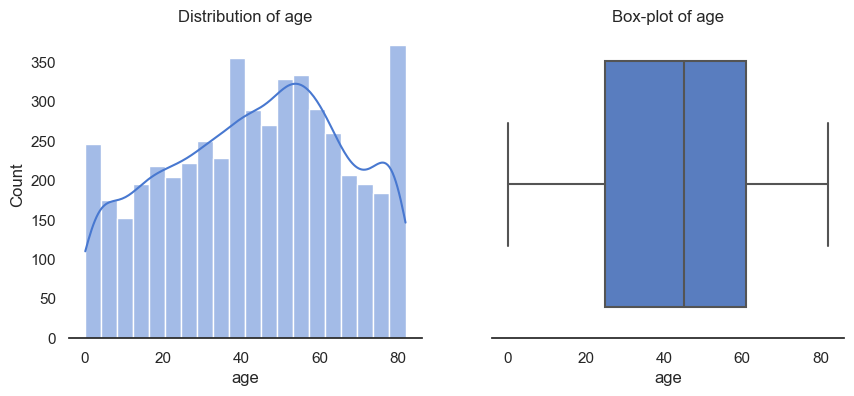

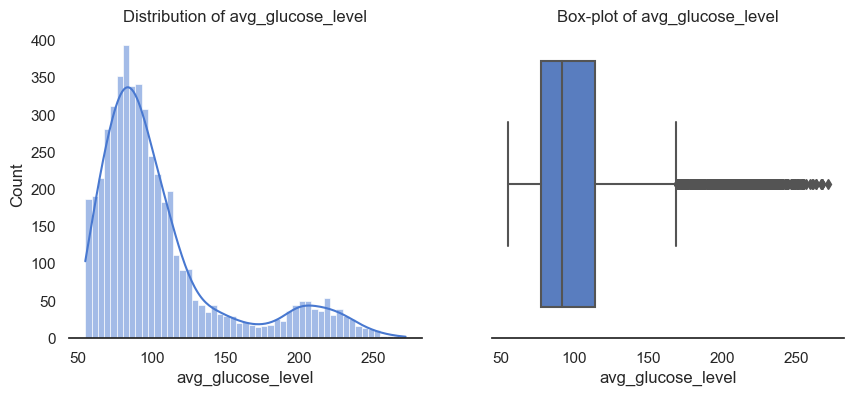

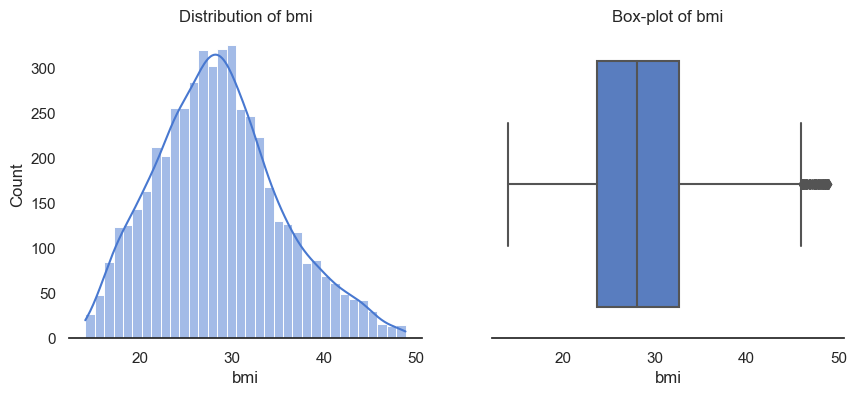

In [12]:
bs_op.numerical_viz()

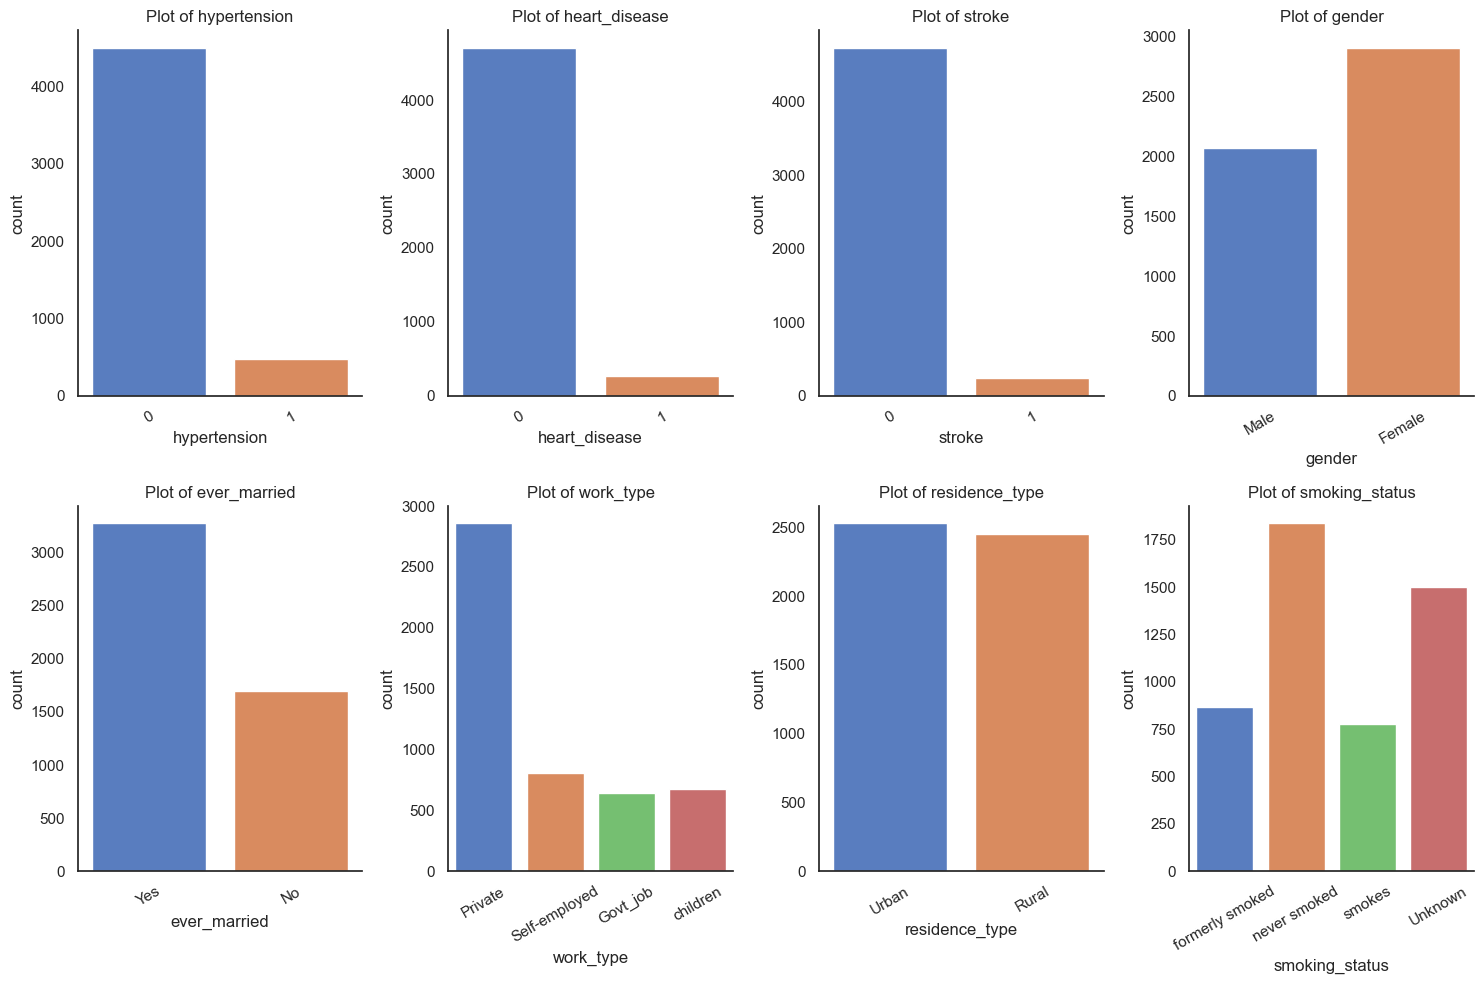

In [13]:
bs_op.categorical_viz()

           age  avg_glucose_level   bmi
skew     -0.14               1.59  0.37
kurtosis -0.99               1.75 -0.14
******************************
Skewness and kurtosis were detected.
Variable: avg_glucose_level
We'll apply Box-Cox transformation.


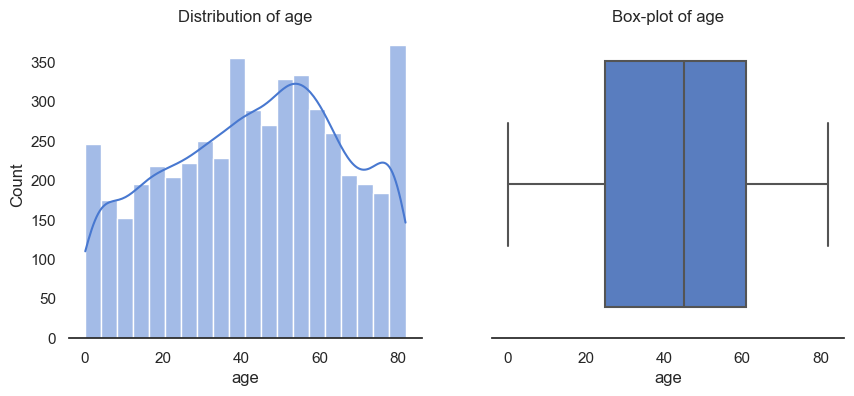

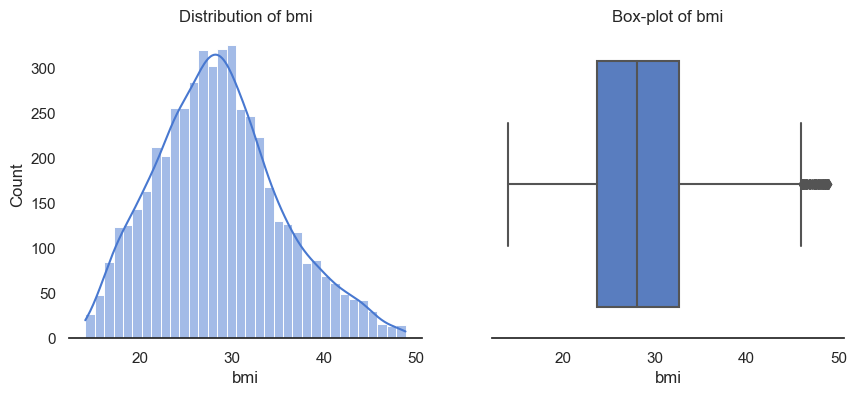

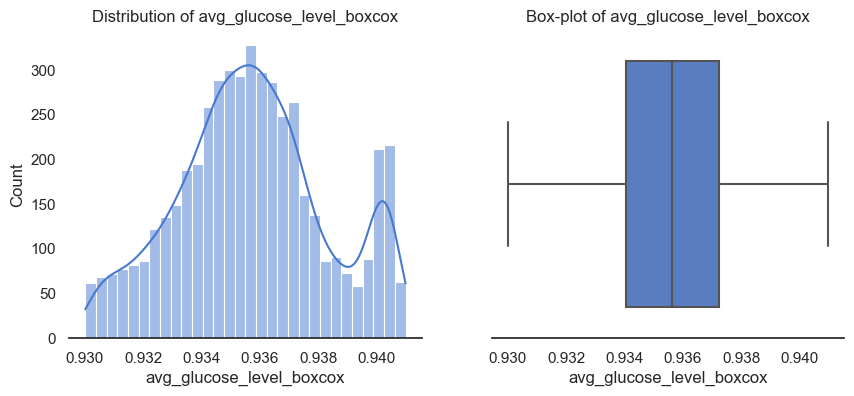

In [14]:
bs_op.skewness_kurtosis()

### EDA